In [ ]:
# Local clone
! git clone https://github.com/nanopiero/CML_processing_by_ML.git

In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np

import sys
sys.path.append('CML_processing_by_ML')
from src.utils.simulation import create_dataloader
import src.utils.architectures_fcn
from src.utils.architectures import load_archi
from src.utils.architectures_fcn import UNet_causal_5mn_atrous, UNet_causal_5mn_atrous_rescale

In [3]:
# Dictionary with pseudo "distances" (distances between two antennnas) for 1,000 pseudo CML ids.
idx2distance = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
duration = 4096  # Duration for each tensor pair
batch_size = 100  # Number of samples per batch
dataloader = create_dataloader(duration, idx2distance, batch_size)

In [4]:
# Here we samples 64 ground-truth rainy processes and their noisy counterpart
# A rainy process is modeled by a 1-d Neymann-Scott process
# The Intensity of the Poisson process for parent events is 0.05 x distance
# The resulting rainy process is divided by the distance to give the "ground truth"
# while it is corrupted through the following steps to yield "noisy_series":
# - applying a non linear conversion to an attenuation in db
# - applying a "wet antenna convolution filter" (kind of sliding mean)
# - adding a high (gaussian noise with non linear dependance of sigma wrt the intensity)
# - adding a low frequency random processes

for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
  if batch_idx == 0:
    break

In [ ]:
import matplotlib.pyplot as plt
sigma = 2
for k in range(5):
  print(idxs[k], dists[k])
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), ground_truths[k], label='ground_truth')
  plt.plot(np.arange(duration), noisy_series[k], label='predictor')
  plt.title(f'Inputs and Targets for the CML n°{idxs[k].item():.0f} (ditance: {dists[k].item():.2f})')
  plt.xlabel('Time (minutes)')
  plt.ylabel('Event Density')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

In [5]:
arch = "UNet_causal_5mn_atrous"
nchannels = 1
nclasses = 1 # Regression only
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 0

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 300  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/300], Loss: 0.4397
Epoch [2/300], Loss: 0.2691
Epoch [3/300], Loss: 0.2495
Epoch [4/300], Loss: 0.2349
Epoch [5/300], Loss: 0.2234
Epoch [6/300], Loss: 0.2157
Epoch [7/300], Loss: 0.2090
Epoch [8/300], Loss: 0.2075
Epoch [9/300], Loss: 0.1970
Epoch [10/300], Loss: 0.1781
Epoch [11/300], Loss: 0.1726
Epoch [12/300], Loss: 0.1661
Epoch [13/300], Loss: 0.1628
Epoch [14/300], Loss: 0.1582
Epoch [15/300], Loss: 0.1543
Epoch [16/300], Loss: 0.1535
Epoch [17/300], Loss: 0.1545
Epoch [18/300], Loss: 0.1522
Epoch [19/300], Loss: 0.1488
Epoch [20/300], Loss: 0.1471
Epoch [21/300], Loss: 0.1476
Epoch [22/300], Loss: 0.1500
Epoch [23/300], Loss: 0.1481
Epoch [24/300], Loss: 0.1457
Epoch [25/300], Loss: 0.1478
Epoch [26/300], Loss: 0.1481
Epoch [27/300], Loss: 0.1470
Epoch [28/300], Loss: 0.1450
Epoch [29/300], Loss: 0.1455
Epoch [30/300], Loss: 0.1450
Epoch [31/300], Loss: 0.1428
Epoch [32/300], Loss: 0.1447
Epoch [33/300], Loss: 0.1418
Epoch [34/300], Loss: 0.1452
Epoch [35/300], Loss: 0

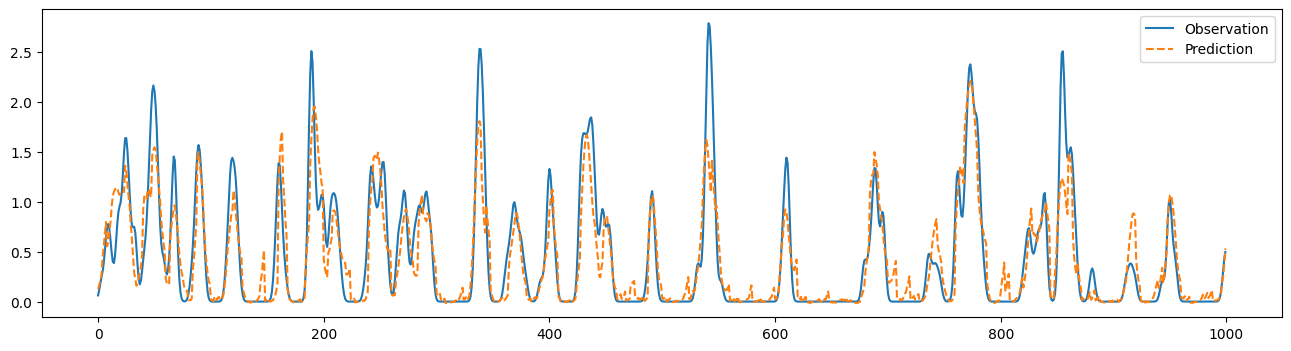

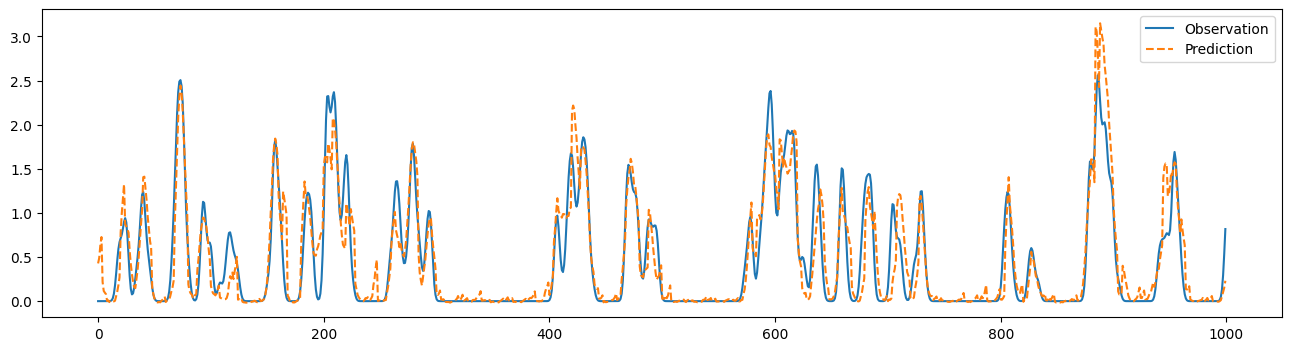

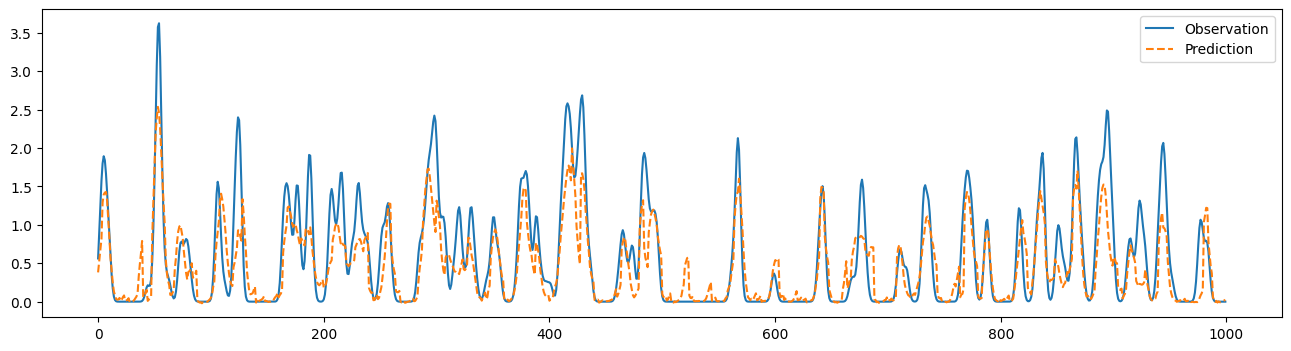

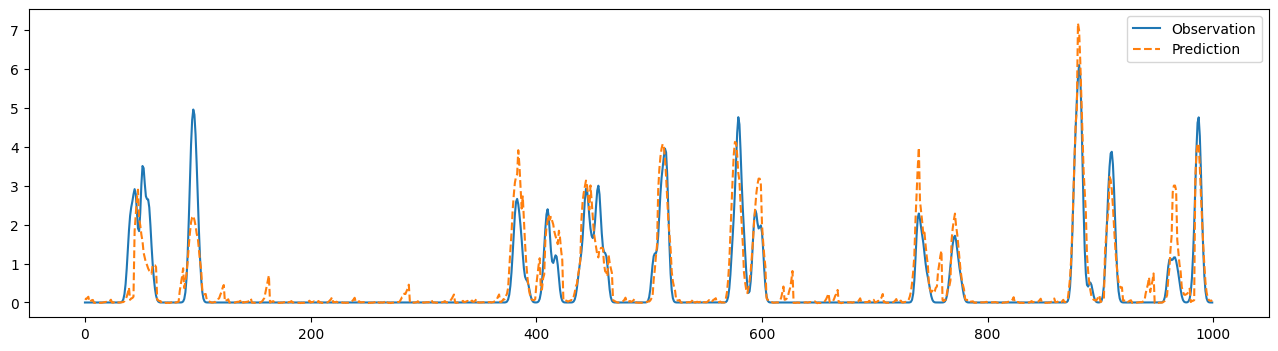

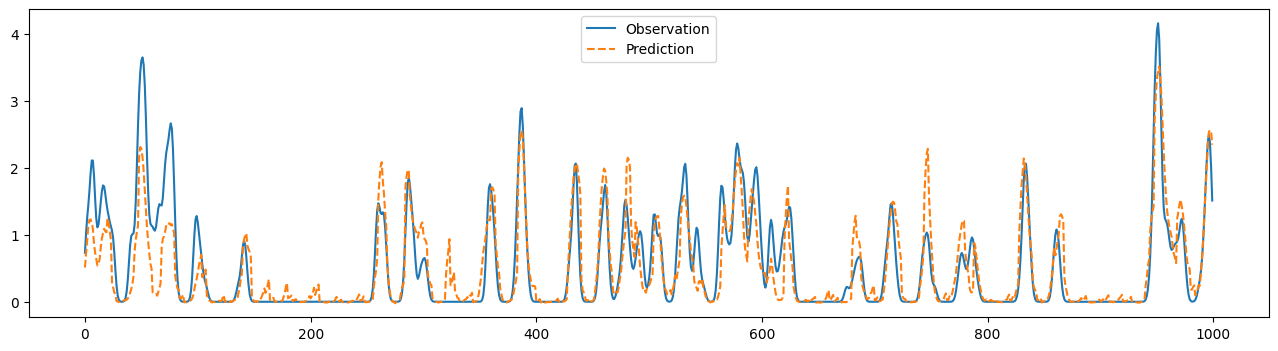

In [6]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=1):
    model.eval()
    L = 1000
    with torch.no_grad():
        for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()

            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(ground_truths[i,:L].squeeze(), label='Observation')
                plt.plot(outputs[i].squeeze()[:L], label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch

visualize_predictions(model, dataloader, num_samples=5)


In [ ]:
# How to do better ?

# An attempt with UNet_causal_5mn_atrous_rescale

In [7]:
arch = "UNet_causal_5mn_atrous_rescale"
nchannels = 1
nclasses = 1 # Regression only
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 1005

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 300  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        outputs, p = model(inputs, indices=idxs.to(device))
        outputs[:,:,:] *= p[5:].view(outputs.shape[0],1,1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/300], Loss: 0.5687
Epoch [2/300], Loss: 0.2885
Epoch [3/300], Loss: 0.2624
Epoch [4/300], Loss: 0.2460
Epoch [5/300], Loss: 0.2383
Epoch [6/300], Loss: 0.2320
Epoch [7/300], Loss: 0.2259
Epoch [8/300], Loss: 0.2180
Epoch [9/300], Loss: 0.2113
Epoch [10/300], Loss: 0.2100
Epoch [11/300], Loss: 0.2044
Epoch [12/300], Loss: 0.2027
Epoch [13/300], Loss: 0.1969
Epoch [14/300], Loss: 0.1775
Epoch [15/300], Loss: 0.1658
Epoch [16/300], Loss: 0.1605
Epoch [17/300], Loss: 0.1561
Epoch [18/300], Loss: 0.1532
Epoch [19/300], Loss: 0.1534
Epoch [20/300], Loss: 0.1493
Epoch [21/300], Loss: 0.1474
Epoch [22/300], Loss: 0.1510
Epoch [23/300], Loss: 0.1482
Epoch [24/300], Loss: 0.1465
Epoch [25/300], Loss: 0.1444
Epoch [26/300], Loss: 0.1425
Epoch [27/300], Loss: 0.1428
Epoch [28/300], Loss: 0.1426
Epoch [29/300], Loss: 0.1424
Epoch [30/300], Loss: 0.1425
Epoch [31/300], Loss: 0.1438
Epoch [32/300], Loss: 0.1427
Epoch [33/300], Loss: 0.1423
Epoch [34/300], Loss: 0.1407
Epoch [35/300], Loss: 0

In [ ]:
arch = "UNet_causal_5mn_atrous_complex_rescale"
nchannels = 1
nclasses = 7
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 0

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 300  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        use_first_network = torch.rand(idxs.shape, device=inputs.device) > 0.75
        idxs[use_first_network] = -1
        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([100, 1, 4096])) that is different to the input size (torch.Size([100, 7, 4096])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/300], Loss: 0.7794
Epoch [2/300], Loss: 0.3845
Epoch [3/300], Loss: 0.3147
Epoch [4/300], Loss: 0.2921
Epoch [5/300], Loss: 0.2807
Epoch [6/300], Loss: 0.2640
Epoch [7/300], Loss: 0.2468
Epoch [8/300], Loss: 0.2345
Epoch [9/300], Loss: 0.2313
Epoch [10/300], Loss: 0.2294
Epoch [11/300], Loss: 0.2214
Epoch [12/300], Loss: 0.2126
Epoch [13/300], Loss: 0.2038
Epoch [14/300], Loss: 0.2062
Epoch [15/300], Loss: 0.2026
Epoch [16/300], Loss: 0.2028
Epoch [17/300], Loss: 0.1997
Epoch [18/300], Loss: 0.1965
Epoch [19/300], Loss: 0.1923
Epoch [20/300], Loss: 0.1927
Epoch [21/300], Loss: 0.1944
Epoch [22/300], Loss: 0.1926
Epoch [23/300], Loss: 0.1885
Epoch [24/300], Loss: 0.1863
Epoch [25/300], Loss: 0.1883
Epoch [26/300], Loss: 0.1864
Epoch [27/300], Loss: 0.1896
Epoch [28/300], Loss: 0.1879
Epoch [29/300], Loss: 0.1828
Epoch [30/300], Loss: 0.1835
Epoch [31/300], Loss: 0.1816
Epoch [32/300], Loss: 0.1792
Epoch [33/300], Loss: 0.1826
Epoch [34/300], Loss: 0.1771
Epoch [35/300], Loss: 0

In [ ]:
"""
for k, linear1 in enumerate(model.linears1):
  if k > 0:
    for j, param in enumerate(linear1.parameters()):
      param.data = list(model.linears1[0].parameters())[j].data

for k, linear2 in enumerate(model.linears2):
  if k > 0:
    for i, param in enumerate(linear2.parameters()):
      param.data = list(model.linears2[0].parameters())[i].data


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
"""
num_epochs = 3

model.freeze_generic_parts()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/3], Loss: 0.1254
Epoch [2/3], Loss: 0.1262
Epoch [3/3], Loss: 0.1262
